# Load combined data csv file

In [1]:
# pip install numpy==1.19.5  <-- needed numpy 1.19.5 to run LSTM function

In [2]:
# import all necessary libraries
import requests
import json
import sqlite3 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
print(np.__version__)

1.19.5


In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [5]:
# import FB Prophet libraries
from fbprophet import Prophet as proph
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

In [6]:
# import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

In [7]:
# import LSTM libraries
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

In [9]:
# this is not necessary but helps to run notebook faster
%config Completer.use_jedi = False

In [10]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [11]:
#Clear warnings
import warnings
warnings.filterwarnings("ignore")

In [12]:
# Set styles of visualizations
sns.set_style('darkgrid')
sns.set_context('poster')

In [13]:
pd.set_option("display.max_columns", 50)

In [14]:
combined = pd.read_csv('data/combined.csv')

In [15]:
# drop column 'Unnamed: 0'
combined.drop(columns=['Unnamed: 0'], inplace=True)

In [16]:
combined.shape

(26665, 28)

In [17]:
# change column 'Sale Date' to datetime
combined['sale_date'] = pd.to_datetime(combined['sale_date'], infer_datetime_format=True)

In [18]:
combined.columns

Index(['sale_date', 'item_name', 'quantity', 'transaction_id', 'listing_id',
       'ship_city', 'ship_state', 'ship_zipcode', 'ship_country', 'order_id',
       'variations', 'state', 'user_id', 'category_id', 'title', 'description',
       'tags', 'shop_section_id', 'featured_rank', 'views', 'num_favorers',
       'occasion', 'style', 'is_customizable', 'has_variations', 'taxonomy_id',
       'taxonomy_path', 'main_tag'],
      dtype='object')

# Create a stationarity check

In [19]:
# Create a function to check for the stationarity of a given time series using rolling stats and DF test
# Collect and package the code from previous labs

def stationarity_check(TS):
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=12, center=False).mean()
    roll_std = TS.rolling(window=12, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['quantity'])
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(TS, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

# Modeling for Category 1 data

In [20]:
cat_data = combined[combined.main_tag == 'cat_1'].groupby('sale_date')['quantity'].sum()

In [21]:
cat_data = pd.DataFrame(cat_data)

In [22]:
len(cat_data)

348

Looks like there were days when this category hasn't been bought. Need to fill in the missing dates with 0

In [23]:
cat_data.sum()

quantity    3399
dtype: int64

In [24]:
dates = pd.date_range(start='2020-01-01', end='2020-12-31')
type(dates)

pandas.core.indexes.datetimes.DatetimeIndex

In [25]:
dates = pd.DataFrame(dates)

In [26]:
dates.columns = ['sale_date']

In [27]:
cat_data = pd.merge(left=dates, right=cat_data, on='sale_date', how='left')

In [28]:
cat_data.isna().sum()

sale_date     0
quantity     18
dtype: int64

In [29]:
cat_data.sum()

quantity    3399.0
dtype: float64

In [30]:
cat_data.fillna(0, inplace=True)

In [31]:
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   sale_date  366 non-null    datetime64[ns]
 1   quantity   366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.6 KB


In [32]:
cat_data.set_index('sale_date', inplace=True)

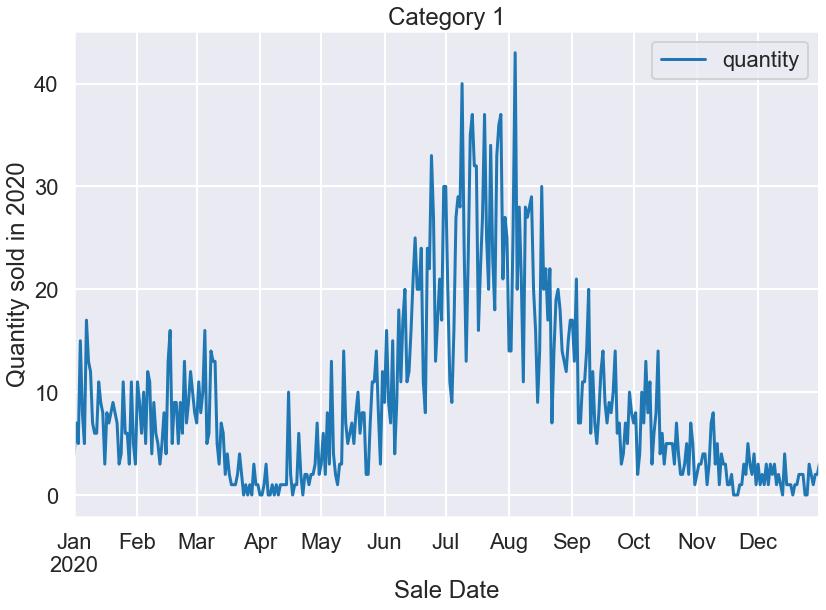

In [33]:
fig, ax = plt.subplots(figsize = (12,9))
cat_data.plot(ax=ax, legend=True)
plt.title('Category 1')
plt.xlabel('Sale Date')
plt.ylabel('Quantity sold in 2020')
fig.tight_layout()
plt.savefig('images/cat1_chart.jpeg', format='jpeg');

## Stationarity checks for Category 1 data

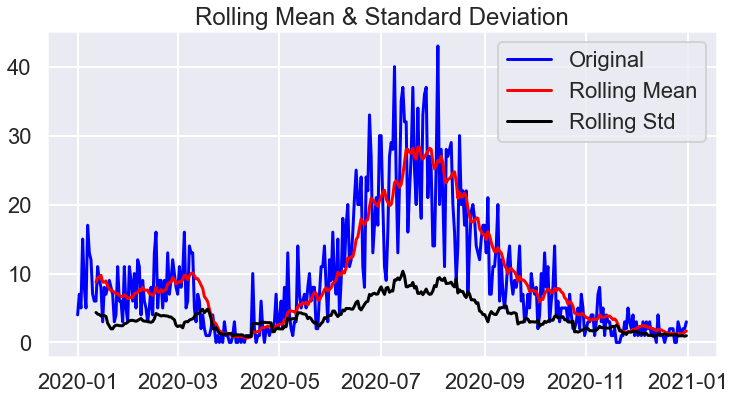

Results of Dickey-Fuller Test: 

Test Statistic                  -1.386494
p-value                          0.588734
#Lags Used                      17.000000
Number of Observations Used    348.000000
Critical Value (1%)             -3.449282
Critical Value (5%)             -2.869881
Critical Value (10%)            -2.571214
dtype: float64


In [34]:
stationarity_check(cat_data)

The time series is not stationary, as the p-value is substantial (0.59 instead of smaller than the typical threshold value 0.05). Let's difference the data.

In [35]:
# Difference your data
cat_diff = cat_data.diff()

# Drop the missing values
cat_diff.dropna(inplace=True)

# Check out the first few rows
cat_diff.head()

,quantity
sale_date,
2020-01-02,3.0
2020-01-03,-2.0
2020-01-04,10.0
2020-01-05,-7.0
2020-01-06,-3.0


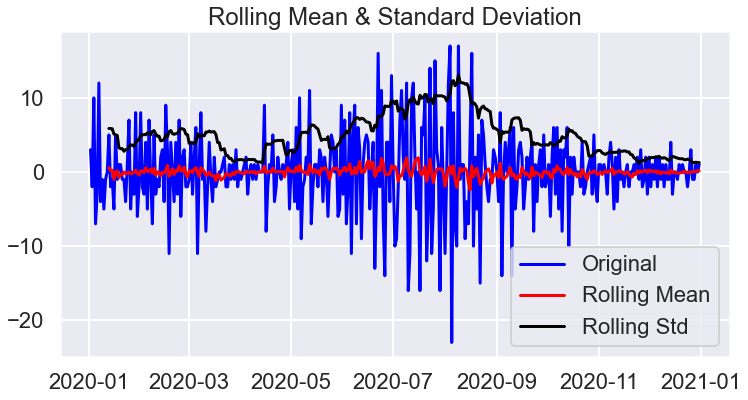

Results of Dickey-Fuller Test: 

Test Statistic                  -3.489370
p-value                          0.008264
#Lags Used                      17.000000
Number of Observations Used    347.000000
Critical Value (1%)             -3.449337
Critical Value (5%)             -2.869906
Critical Value (10%)            -2.571227
dtype: float64


In [36]:
stationarity_check(cat_diff)

The p-value of the Dickey-Fuller test <0.05, so this series seems to be stationary according to this test! But let's try to difference this data again.

In [37]:
# Difference your data
cat_diff_2 = cat_diff.diff()

# Drop the missing values
cat_diff_2.dropna(inplace=True)

# Check out the first few rows
cat_diff_2.head()

,quantity
sale_date,
2020-01-03,-5.0
2020-01-04,12.0
2020-01-05,-17.0
2020-01-06,4.0
2020-01-07,15.0


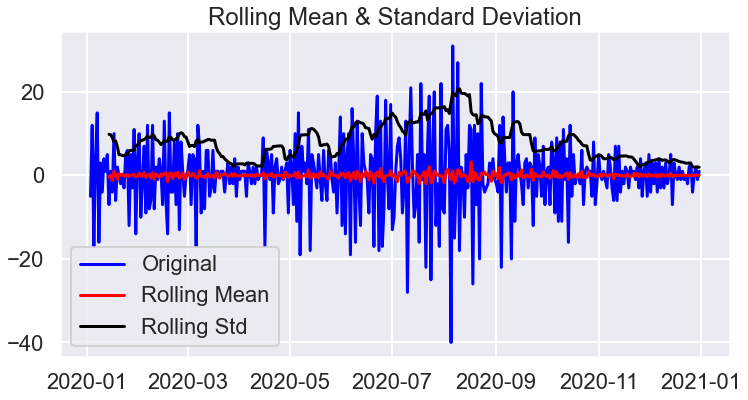

Results of Dickey-Fuller Test: 

Test Statistic                -1.113779e+01
p-value                        3.163258e-20
#Lags Used                     1.600000e+01
Number of Observations Used    3.470000e+02
Critical Value (1%)           -3.449337e+00
Critical Value (5%)           -2.869906e+00
Critical Value (10%)          -2.571227e+00
dtype: float64


In [38]:
stationarity_check(cat_diff_2)

 The outcome of differencing data twice is better for stationarity. Let's try modeling with d=1,2.

## ACF and PACF for Category 1 data - differenced once

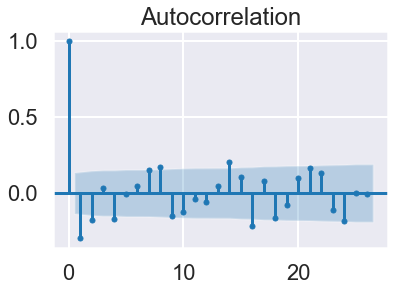

In [39]:
plot_acf(cat_diff['quantity'], alpha=.01);

Based on ACF graph above, we need to include up to q=5 terms in ARIMA

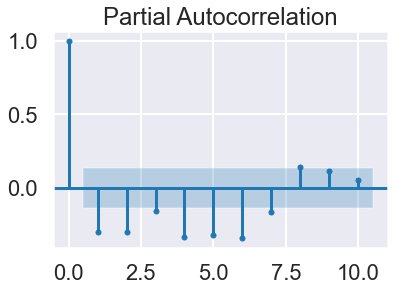

In [40]:
plot_pacf(cat_diff['quantity'], alpha=.01, lags=10);

Based on PACF graph above, we need to include up to p=9 terms in ARIMA

## ACF and PACF for Category 1 data - differenced twice

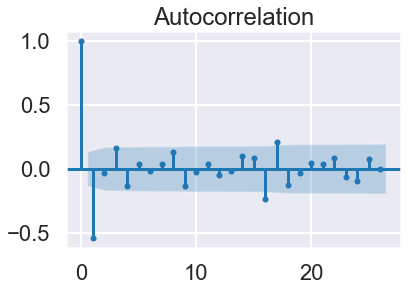

In [41]:
plot_acf(cat_diff_2['quantity'], alpha=.01);

Based on ACF graph above, we need to include up to q=4 terms in ARIMA

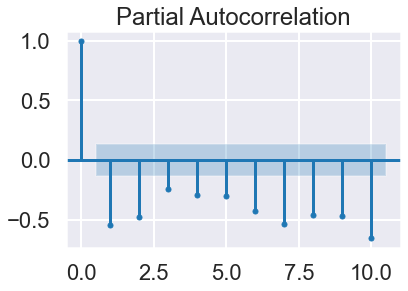

In [42]:
plot_pacf(cat_diff_2['quantity'], alpha=.01, lags=10);

Based on PACF graph above, we need to include up to p=10 terms in ARIMA

## ARIMA model

### Train test split the data

In [43]:
cat_data_train = cat_data[:round(len(cat_data) * 0.8)]
cat_data_test = cat_data[round(len(cat_data) * 0.8):]
cat_data_test.shape

(73, 1)

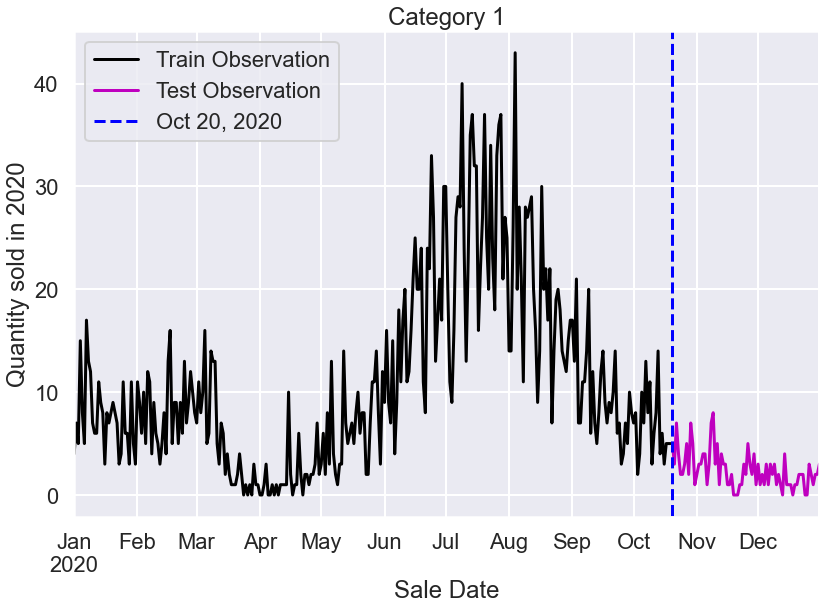

In [84]:
fig, ax = plt.subplots(figsize = (12,9))
cat_data_train.plot(ax=ax, legend=True, color='black')
cat_data_test.plot(ax=ax, legend=True, color='m')
plt.axvline(x='2020-10-20', ymin=-2, ymax=35, color='b', linestyle='--')
plt.title('Category 1')
plt.xlabel('Sale Date')
plt.ylabel('Quantity sold in 2020')
plt.legend(('Train Observation', 'Test Observation', 'Oct 20, 2020'))
fig.tight_layout()
plt.savefig('images/cat1_chart_train_test.jpeg', format='jpeg');

### Grid search for hyperparameters with ARIMA

In [45]:
orderlist = []
aiclist = []
rmselist = []
badlist = []
for p in tqdm(range(0,10)):
    for d in range(1,3):
        for q in range(0,6):
            try:
                ordernow = (p,d,q)
                arimax_now = ARIMA(cat_data_train, order=ordernow).fit(disp=0)
                rmselist.append(np.sqrt(mean_squared_error(cat_data_test, arimax_now.forecast(73)[0])))
                orderlist.append(ordernow)
                aiclist.append(arimax_now.aic)
            except:
                badlist.append(ordernow)
                continue

  0%|          | 0/10 [00:00<?, ?it/s]

In [46]:
badlist

[(1, 1, 2),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 4),
 (1, 2, 5),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 2, 5),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3),
 (3, 2, 4),
 (3, 2, 5),
 (4, 2, 1),
 (4, 2, 2),
 (4, 2, 3),
 (4, 2, 4),
 (4, 2, 5),
 (5, 2, 1),
 (5, 2, 2),
 (5, 2, 4),
 (5, 2, 5),
 (6, 2, 2),
 (6, 2, 5),
 (7, 2, 4),
 (7, 2, 5),
 (8, 1, 2),
 (8, 1, 3),
 (8, 1, 4),
 (8, 1, 5),
 (9, 1, 4),
 (9, 1, 5)]

In [47]:
df_arima = pd.DataFrame()
df_arima['order'], df_arima['aic'], df_arima['rmse'] = orderlist, aiclist, rmselist

In [48]:
df_arima.sort_values('aic').head(15)

,order,aic,rmse
45,"(5, 1, 5)",1707.618281,3.441506
53,"(6, 1, 5)",1707.751629,3.550459
36,"(4, 1, 3)",1707.892445,3.661466
38,"(4, 1, 5)",1707.968033,4.241643
37,"(4, 1, 4)",1709.066463,3.854955
43,"(5, 1, 3)",1709.378960,3.812921
31,"(3, 1, 5)",1709.489017,3.775088
24,"(2, 1, 5)",1709.829602,3.673327
63,"(7, 1, 5)",1709.848063,3.794603
50,"(6, 1, 2)",1710.105143,3.553733


### ARIMA with order=(4,1,5)
This is the best model according to the search above. Some models with better AIC/RMSE scores were rejected due to p-values of variables  > 0.05 in ARIMA Model Results below

In [57]:
model_cat=ARIMA(cat_data_train, order=(4,1,5))
model_cat_fit = model_cat.fit(disp=0)
print(model_cat_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.quantity   No. Observations:                  292
Model:                 ARIMA(4, 1, 5)   Log Likelihood                -842.984
Method:                       css-mle   S.D. of innovations              4.246
Date:                Wed, 31 Mar 2021   AIC                           1707.968
Time:                        15:56:03   BIC                           1748.412
Sample:                    01-02-2020   HQIC                          1724.168
                         - 10-19-2020                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0043      0.058     -0.074      0.941      -0.118       0.110
ar.L1.D.quantity    -0.5064      0.028    -17.841      0.000      -0.562      -0.451
ar.L2.D.quantity     0.3139 

<AxesSubplot:xlabel='sale_date'>

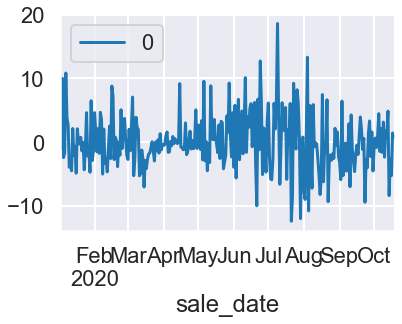

In [58]:
residuals = pd.DataFrame(model_cat_fit.resid)
residuals.plot()

<AxesSubplot:ylabel='Density'>

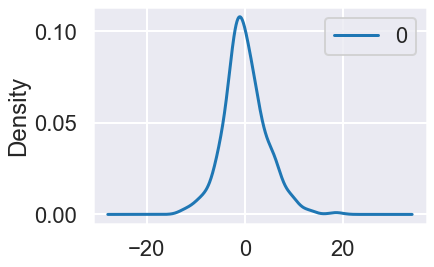

In [59]:
residuals.plot(kind='kde')

In [60]:
model_cat_fit.forecast(73)[0]

array([5.79862897, 8.53163683, 7.45246974, 8.16859664, 4.53922859,
       4.79110983, 4.04875776, 6.03300107, 7.88322405, 7.77832386,
       7.8725703 , 4.8903783 , 4.82427062, 3.94731237, 6.06782487,
       7.41826242, 7.97501783, 7.61594806, 5.24947165, 4.77910947,
       3.98002877, 5.97004822, 7.10254439, 8.04399761, 7.43040306,
       5.56152143, 4.72318782, 4.07509213, 5.80193833, 6.89062601,
       8.01048443, 7.31578703, 5.80606745, 4.69236267, 4.185418  ,
       5.61103037, 6.74042198, 7.90690405, 7.25606292, 5.98413442,
       4.69928264, 4.2855194 , 5.42795119, 6.61989855, 7.76308749,
       7.23048332, 6.10742015, 4.74226895, 4.36567181, 5.26864963,
       6.50845723, 7.60182361, 7.22016275, 6.19074112, 4.81263898,
       4.4258652 , 5.13841333, 6.39536569, 7.43799093, 7.21102722,
       6.24761181, 4.89979835, 4.47084172, 5.03599616, 6.27700794,
       7.27966822, 7.19435182, 6.28827712, 4.99420156, 4.50666071,
       4.95698856, 6.15408158, 7.1300252 ])

In [112]:
# create datasets that contain lower and upper bounds of confidence interval
lower = []
upper = []
for i in range(73):
    lower.append(model_cat_fit.forecast(73)[2][i][0])
    upper.append(model_cat_fit.forecast(73)[2][i][1])

In [61]:
arima_aic = model_cat_fit.aic
arima_rmse = np.sqrt(mean_squared_error(cat_data_test, model_cat_fit.forecast(73)[0]))
print('AIC:', arima_aic)
print('RMSE:', arima_rmse)

AIC: 1707.9680328188786
RMSE: 4.241642913750046


In [62]:
dates_test = pd.date_range(start='2020-10-20', end='2020-12-31')

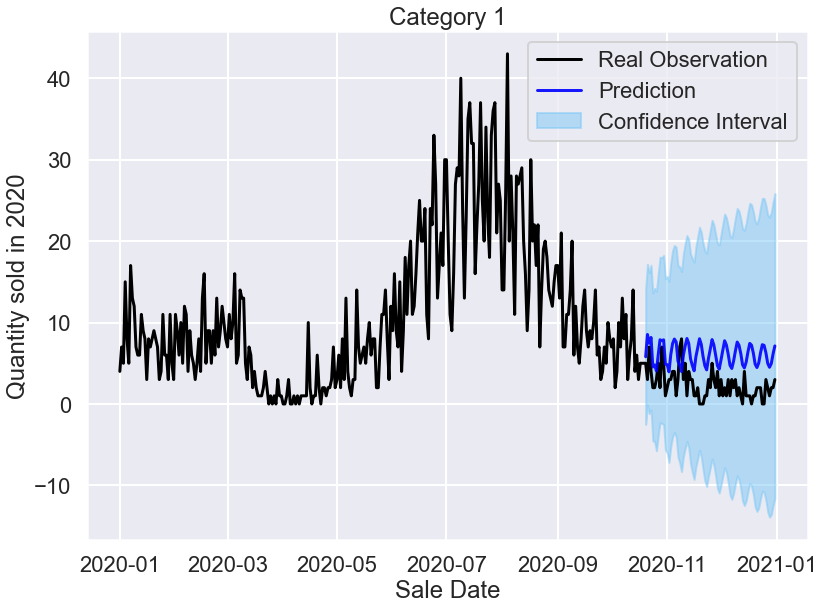

In [115]:
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(cat_data, color='black')
ax.plot(dates_test, model_cat_fit.forecast(73)[0], alpha=0.9, color='blue')

# Plot the range for confidence intervals
ax.fill_between(dates_test,
                lower,
                upper, color='#7BC8F6', alpha=0.5)

plt.title('Category 1')
plt.xlabel('Sale Date')
plt.ylabel('Quantity sold in 2020')
plt.legend(('Real Observation', 'Prediction', 'Confidence Interval'))
fig.tight_layout()
plt.savefig('images/cat1_ARIMA_4_1_5.jpeg', format='jpeg');

##  SARIMAX model

### Load external data

In [64]:
cat_API = pd.read_csv('data/party_decorations_API.csv')

In [65]:
cat_API.shape

(366, 6)

In [66]:
# change column 'date' to datetime
cat_API['date'] = pd.to_datetime(cat_API['date'], infer_datetime_format=True)

In [67]:
cat_API.head()

,date,unscaled,monthly,isPartial,scale,cat
0,2020-01-01,36,0.0,0,0.00,0.00
1,2020-01-02,100,0.0,0,0.00,0.00
2,2020-01-03,78,0.0,0,0.00,0.00
3,2020-01-04,87,0.0,0,0.00,0.00
4,2020-01-05,54,82.0,False,0.82,44.28


Looks like there were days when this category hasn't been bought. Need to fill in the missing dates with 0

In [68]:
cat_API.sum()

unscaled                                                 23888
monthly                                                  22855
isPartial    0000False000000False000000False000000False0000...
scale                                                   228.55
cat                                                    15414.3
dtype: object

In [70]:
# merge cat_API with earlier created dataframe dates in case cat_API was missing information for any dates
cat_API = pd.merge(left=dates, right=cat_API, left_on='sale_date', right_on='date', how='left')

In [71]:
cat_API.isna().sum()

sale_date    0
date         0
unscaled     0
monthly      0
isPartial    0
scale        0
cat          0
dtype: int64

In [72]:
# check that .sum() hasn't changed
cat_API.sum()

unscaled                                                 23888
monthly                                                  22855
isPartial    0000False000000False000000False000000False0000...
scale                                                   228.55
cat                                                    15414.3
dtype: object

In [73]:
# fill NA with 0 in case data was missing
cat_API.fillna(0, inplace=True)

In [74]:
cat_API.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   sale_date  366 non-null    datetime64[ns]
 1   date       366 non-null    datetime64[ns]
 2   unscaled   366 non-null    int64         
 3   monthly    366 non-null    float64       
 4   isPartial  366 non-null    object        
 5   scale      366 non-null    float64       
 6   cat        366 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 22.9+ KB


In [75]:
# set index to column 'date'
cat_API.set_index('date', inplace=True)  

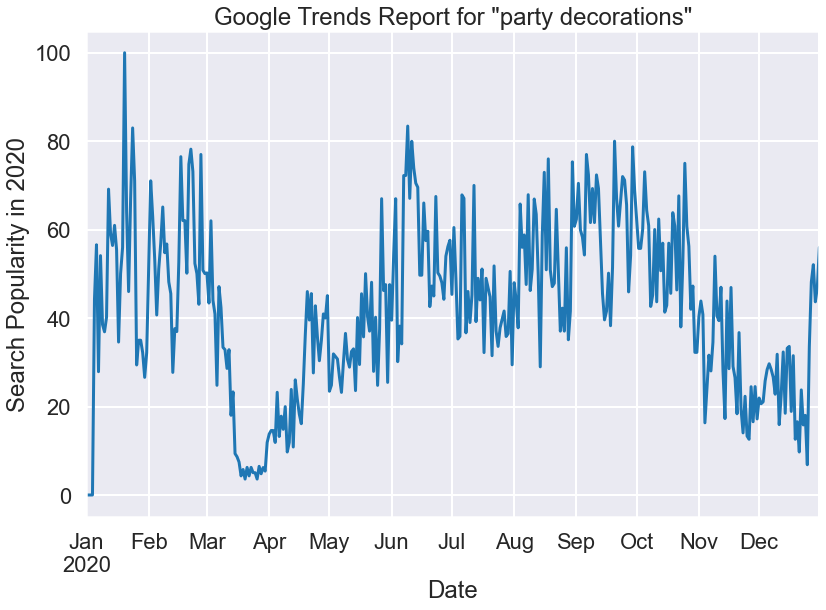

In [79]:
fig, ax = plt.subplots(figsize = (12,9))
cat_API.cat.plot(ax=ax)  
plt.title('Google Trends Report for "party decorations"')
plt.xlabel('Date')
plt.ylabel('Search Popularity in 2020')
fig.tight_layout()
plt.savefig('images/cat1_API_chart.jpeg', format='jpeg');

### Train test split the external data

In [81]:
cat_API_train = cat_API[:round(len(cat_API) * 0.8)]
cat_API_test = cat_API[round(len(cat_API) * 0.8):]
cat_API_test.shape

(73, 6)

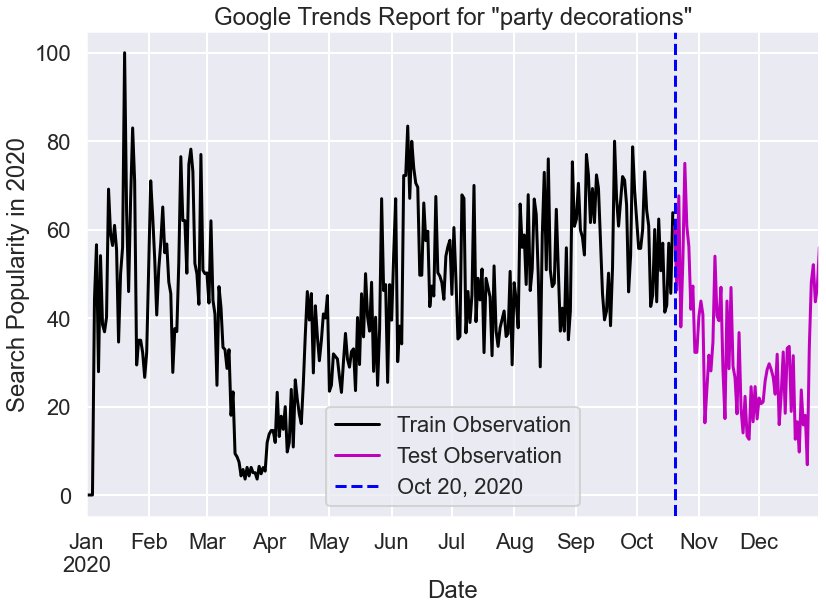

In [85]:
fig, ax = plt.subplots(figsize = (12,9))
cat_API_train.cat.plot(ax=ax, legend=True, color='black')
cat_API_test.cat.plot(ax=ax, legend=True, color='m')
plt.axvline(x='2020-10-20', ymin=-2, ymax=35, color='b', linestyle='--')
plt.title('Google Trends Report for "party decorations"')
plt.xlabel('Date')
plt.ylabel('Search Popularity in 2020')
plt.legend(('Train Observation', 'Test Observation', 'Oct 20, 2020'))
fig.tight_layout()
plt.savefig('images/cat1_API_train_test.jpeg', format='jpeg');

### Grid search for hyperparameters

In [86]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 4) for x in pdq]

In [87]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
badlist = []
for comb in tqdm(pdq):
    for combs in tqdm(pdqs):
        try:
            mod = sm.tsa.statespace.SARIMAX(cat_data_train,
                                            exog=cat_API_train.cat,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
        except:
            badlist.append(ordernow)
            continue

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [88]:
badlist

[]

In [91]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.sort_values('aic').head(15)

,pdq,pdqs,aic
61,"(1, 1, 1)","(1, 0, 1, 4)",1732.980038
63,"(1, 1, 1)","(1, 1, 1, 4)",1734.375574
29,"(0, 1, 1)","(1, 0, 1, 4)",1734.663791
31,"(0, 1, 1)","(1, 1, 1, 4)",1736.247663
57,"(1, 1, 1)","(0, 0, 1, 4)",1739.793912
59,"(1, 1, 1)","(0, 1, 1, 4)",1741.878595
25,"(0, 1, 1)","(0, 0, 1, 4)",1743.278595
45,"(1, 0, 1)","(1, 0, 1, 4)",1744.877986
60,"(1, 1, 1)","(1, 0, 0, 4)",1745.145803
27,"(0, 1, 1)","(0, 1, 1, 4)",1749.107555


### SARIMAX (1,1,1) and (1,1,1,4)

In [92]:
# Plug the optimal parameter values into a new SARIMAX model
SARIMA_MODEL = sm.tsa.statespace.SARIMAX(cat_data_train,
                                         exog=cat_API_train.cat,
#                                         exog=df.drop('Close', axis=1),
                                        order=(1, 1, 1), 
                                        seasonal_order=(0, 0, 1, 4),
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = SARIMA_MODEL.fit()

output.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
cat,0.0320,0.027,1.177,0.239,-0.021,0.085
ar.L1,0.1614,0.066,2.430,0.015,0.031,0.292
ma.L1,-0.8142,0.044,-18.577,0.000,-0.900,-0.728
ma.S.L4,-0.1363,0.046,-2.934,0.003,-0.227,-0.045
sigma2,24.7220,1.698,14.563,0.000,21.395,28.049


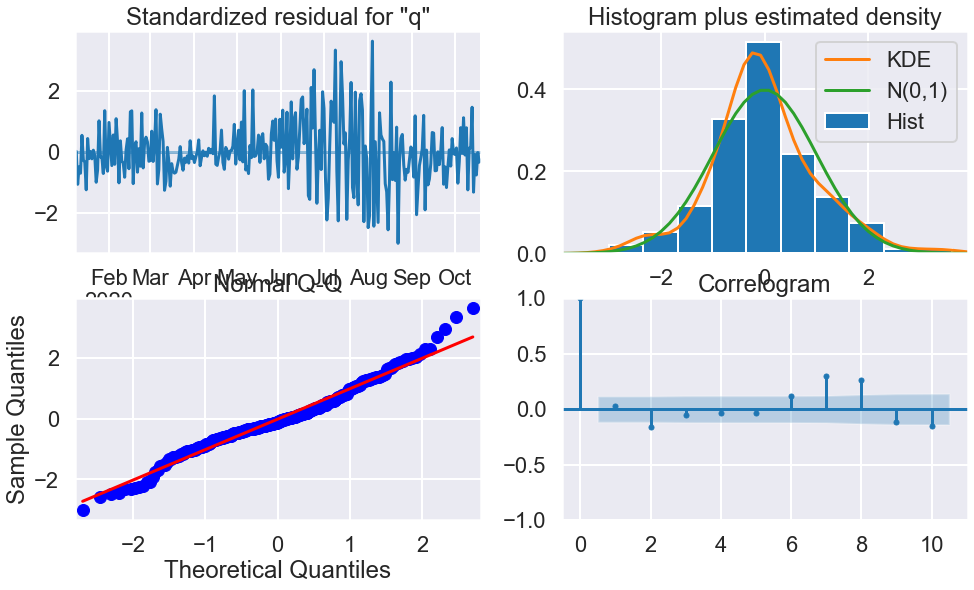

In [93]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(16,9))
plt.show();

In [94]:
# Get predictions for training set and calculate confidence intervals
pred = output.get_prediction(exog=cat_API_test.cat, start=cat_data.index[-73], end=cat_data.index[-1], dynamic=False)
pred_conf = pred.conf_int()

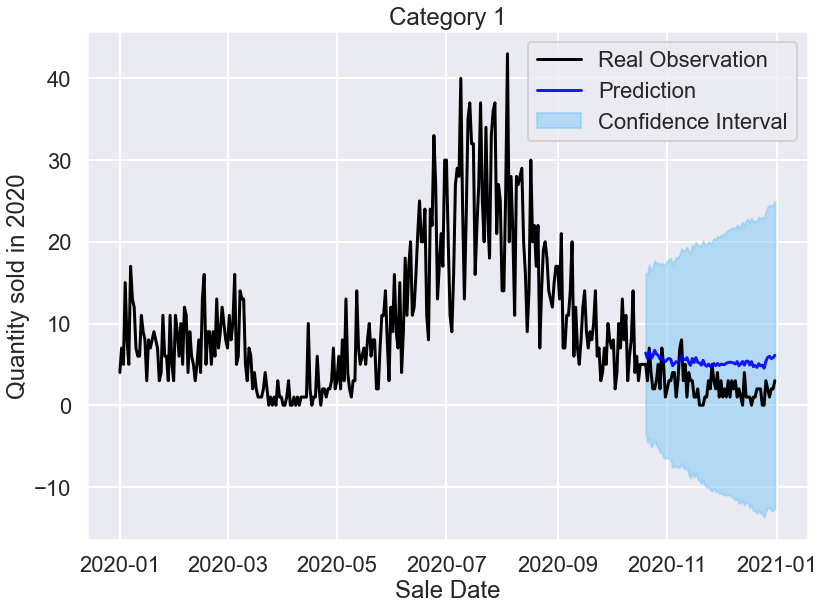

In [95]:
# Plot real vs predicted values along with confidence interval
fig, ax = plt.subplots(figsize=(12,9))
# Plot observed values
ax.plot(cat_data, color='black')

# Plot predicted values
ax.plot(pred.predicted_mean, alpha=0.9, color='blue')

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='#7BC8F6', alpha=0.5)

# Set axes labels and title
plt.title('Category 1')
plt.xlabel('Sale Date')
plt.ylabel('Quantity sold in 2020')
plt.legend(('Real Observation', 'Prediction', 'Confidence Interval'))
fig.tight_layout()
plt.savefig('images/cat1_SARIMAX.jpeg', format='jpeg');

In [96]:
# Get the real and predicted values
close_forecasted = pred.predicted_mean
close_truth = cat_data.quantity[-73:]

In [117]:
# calculate root mean squared error
sarimax_rmse = mean_squared_error(close_truth, close_forecasted, squared=False)
# calculate mean absolute error
sarimax_mae = mean_absolute_error(close_truth, close_forecasted)

print('SARIMAX RMSE: {}'.format(round(sarimax_rmse, 2)))
print('SARIMAX MAE: {}'.format(round(sarimax_mae, 2)))

SARIMAX RMSE: 3.36
SARIMAX MAE: 3.07
